# Chronic Illness Prediction

Task:

As a Data Scientist, your task is to build a predictive model that can accurately classify
members into one of the following categories:

1) Yes: The member has been diagnosed with a chronic condition.
2) Yes, but female told only during pregnancy: The member has been diagnosed with chronic condition.
3) No: The member has not been diagnosed with a chronic condition.


In [1]:
# Data manipulation
import pandas as pd
import numpy as np


# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pipeline for preprocessing and modeling
from sklearn.pipeline import Pipeline

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Metrics for evaluation
from sklearn.metrics import make_scorer, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from scipy.stats import chi2_contingency

# Machine Learning Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


### Loading and inspecting the data

In [2]:
train = pd.read_csv('train.csv') #import the train data
test = pd.read_csv('test.csv') # import the test data

In [3]:
train['Exervise_Status'] = train['Exercise_Status'].astype('category')

In [4]:
print(train[['Age', 'Weight', 'Height', 'Alcohol_Frequency']].describe())

                 Age         Weight         Height  Alcohol_Frequency
count  275236.000000  265485.000000  264803.000000      275236.000000
mean       55.344355     780.393687     823.406389       11289.558542
std        17.592387    2268.496758    1600.589501       31223.715270
min        18.000000      32.000000     209.000000           0.000000
25%        41.000000     150.000000     504.000000           0.000000
50%        58.000000     180.000000     507.000000          47.000000
75%        70.000000     220.000000     511.000000         560.000000
max        80.000000    9999.000000    9999.000000       99900.000000


In [5]:
# Dropping columns that have more than 90% null values
train = train.dropna(axis=1, thresh=0.9)

print(train.columns)

Index(['Age', 'Sex', 'Race', 'Education_Level', 'Income_Level',
       'Marital_Status', 'Employment_Status', 'Number_of_Children', 'Weight',
       'Height', 'Housing_Status', 'Smoking_Status', 'Alcohol_Consumption',
       'Alcohol_Frequency', 'Exercise_Status', 'Sleep_Duration',
       'Asthma_Status', 'Pneumonia_Vaccination_Status', 'General_Health',
       'Physical_Health_Poor_Days', 'Mental_Health_Poor_Days',
       'Difficulty_Walking', 'BMI_Category', 'Arthritis_Status',
       'Coronary_Heart_Disease_Status', 'Stroke_Status', 'COPD_Status',
       'Kidney_Disease_Status', 'Caregiver_Major_Health_Problem',
       'Total_Physical_Inactivity', 'Depression_Status',
       'Primary_Health_Insurance_Source', 'Has_Personal_Doctor',
       'Could_Not_See_Doctor_Due_To_Cost', 'Last_Routine_Checkup',
       'Tetanus_Shot_Status', 'Colonoscopy_Status', 'Mammogram_Status',
       'PSA_Test_Status', 'Flu_Shot_Status', 'Eye_Exam_Status',
       'Last_Dental_Visit', 'Veteran_Status', 'Chron

In [6]:
train.head()

,Age,Sex,Race,Education_Level,Income_Level,Marital_Status,Employment_Status,Number_of_Children,Weight,Height,...,Tetanus_Shot_Status,Colonoscopy_Status,Mammogram_Status,PSA_Test_Status,Flu_Shot_Status,Eye_Exam_Status,Last_Dental_Visit,Veteran_Status,Chronic_Condition,Exervise_Status
0,66,1,1,4.0,99.0,1.0,1.0,88.0,220.0,603.0,...,4.0,1.0,NaN,NaN,2.0,NaN,2.0,2.0,3.0,2.0
1,74,1,1,6.0,7.0,1.0,7.0,88.0,170.0,511.0,...,3.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,3.0,1.0
2,61,1,2,4.0,5.0,5.0,8.0,88.0,170.0,511.0,...,4.0,2.0,NaN,NaN,2.0,NaN,7.0,1.0,3.0,2.0
3,44,2,1,6.0,3.0,5.0,1.0,88.0,150.0,502.0,...,4.0,NaN,2.0,NaN,1.0,NaN,4.0,2.0,3.0,2.0
4,79,1,7,2.0,5.0,6.0,5.0,10.0,275.0,507.0,...,NaN,1.0,NaN,NaN,NaN,NaN,3.0,2.0,1.0,1.0


Important to note that the data is label encoded already

In [7]:
age_bins = [0, 17, 35, 55, np.inf]  
age_labels = [0, 1, 2, 3]  

train['Age_Binned'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels)

print(train[['Age', 'Age_Binned']].head())

   Age Age_Binned
0   66          3
1   74          3
2   61          3
3   44          2
4   79          3


In [8]:
train.head()

,Age,Sex,Race,Education_Level,Income_Level,Marital_Status,Employment_Status,Number_of_Children,Weight,Height,...,Colonoscopy_Status,Mammogram_Status,PSA_Test_Status,Flu_Shot_Status,Eye_Exam_Status,Last_Dental_Visit,Veteran_Status,Chronic_Condition,Exervise_Status,Age_Binned
0,66,1,1,4.0,99.0,1.0,1.0,88.0,220.0,603.0,...,1.0,NaN,NaN,2.0,NaN,2.0,2.0,3.0,2.0,3
1,74,1,1,6.0,7.0,1.0,7.0,88.0,170.0,511.0,...,1.0,NaN,NaN,1.0,NaN,1.0,1.0,3.0,1.0,3
2,61,1,2,4.0,5.0,5.0,8.0,88.0,170.0,511.0,...,2.0,NaN,NaN,2.0,NaN,7.0,1.0,3.0,2.0,3
3,44,2,1,6.0,3.0,5.0,1.0,88.0,150.0,502.0,...,NaN,2.0,NaN,1.0,NaN,4.0,2.0,3.0,2.0,2
4,79,1,7,2.0,5.0,6.0,5.0,10.0,275.0,507.0,...,1.0,NaN,NaN,NaN,NaN,3.0,2.0,1.0,1.0,3


In [9]:
#List of ambiguous values to replace with NaN across all columns
ambiguous_values = ["Don't know/Not sure", "Missing", "BLANK", 7, 8, 77, 88, 9, 7777, 99900]

# Convert all categorical columns to string to handle NaN values
train = train.apply(lambda col: col.astype(str) if col.dtype.name == 'category' else col)


#Replace ambiguous values with NaN for all columns
train = train.replace(ambiguous_values, np.nan)

The handling of all of the ambiguous values is very important for the model to pick up on. The values above do not add anything to the model so they are converted to NaN.

### Feature standardization

In [10]:
def preprocess_height(df):
    # Replace ambiguous values with NaN
    ambiguous_values = [7777, 9999, 'BLANK']
    df['Height'] = df['Height'].replace(ambiguous_values, np.nan)

    # Create a function to convert heights to a consistent unit (e.g., centimeters)
    def convert_height(value):
        if pd.isna(value):  # If value is NaN, return NaN
            return np.nan
        elif 200 <= value <= 711:  # Imperial values (e.g., 508 for 5 feet 8 inches)
            feet = value // 100
            inches = value % 100
            return (feet * 30.48) + (inches * 2.54)  # Convert to centimeters
        elif 9061 <= value <= 9998:  # Metric values indicated by a leading '9'
            return value % 10000  # Extract and return centimeters directly
        else:
            return np.nan  # Handle other invalid values as NaN

    # Apply the conversion function to the height column
    df['Height_cm'] = df['Height'].apply(convert_height)

    # Drop the original Height column and use the new Height_cm column
    df = df.drop(columns=['Height'])
    
    # Print some sample values to verify the conversion
    print(f"Sample height values after conversion:\n{df[['Height_cm']].head()}")
    
    return df

train = preprocess_height(train)

Sample height values after conversion:
   Height_cm
0     190.50
1     180.34
2     180.34
3     157.48
4     170.18


In [11]:
def preprocess_weight(df):
    # Replace ambiguous values with NaN
    ambiguous_values = [7777, 9999, 'BLANK']
    df['Weight'] = df['Weight'].replace(ambiguous_values, np.nan)

    # Function to convert weight
    def convert_weight(value):
        if pd.isna(value):  # If value is NaN, return NaN
            return np.nan
        elif 50 <= value <= 776:  # Weight in pounds
            return value * 0.453592  # Convert pounds to kilograms
        elif 9023 <= value <= 9352:  # Metric values (kilograms)
            return value % 10000  # Extract and return kilograms directly
        else:
            return np.nan  # Handle other invalid values as NaN

    # Apply the conversion function to the weight column
    df['Weight_kg'] = df['Weight'].apply(convert_weight)

    # Drop the original Weight column and use the new Weight_kg column
    df = df.drop(columns=['Weight'])
    
    # Print some sample values to verify the conversion
    print(f"Sample weight values after conversion:\n{df[['Weight_kg']].head()}")
    
    return df

train = preprocess_weight(train)

Sample weight values after conversion:
   Weight_kg
0   99.79024
1   77.11064
2   77.11064
3   68.03880
4  124.73780


### Removing outliers

In [12]:
def remove_outliers(df):
    # Drop rows with NaN in relevant columns before filtering
    df = df.dropna(subset=['Age', 'Weight_kg', 'Height_cm'])
    
    # Remove outliers based on assumed ranges
    df = df[(df['Age'] >= 0) & (df['Age'] <= 80)]
    df = df[(df['Weight_kg'] >= 30) & (df['Weight_kg'] <= 300)]
    df = df[(df['Height_cm'] >= 30) & (df['Height_cm'] <= 200)]
    
    # Ensure the output is not empty
    if df.empty:
        print("Warning: The resulting DataFrame is empty after removing outliers.")
    else:
        print(f"Data after removing outliers (showing first 5 rows):\n{df.head()}")
    
    return df

# Remove unreasonable values from the dataset
train = remove_outliers(train)

Data after removing outliers (showing first 5 rows):
    Age  Sex  Race  Education_Level  Income_Level  Marital_Status  \
0  66.0    1   1.0              4.0          99.0             1.0   
1  74.0    1   1.0              6.0           NaN             1.0   
2  61.0    1   2.0              4.0           5.0             5.0   
3  44.0    2   1.0              6.0           3.0             5.0   
4  79.0    1   NaN              2.0           5.0             6.0   

   Employment_Status  Number_of_Children  Housing_Status  Smoking_Status  ...  \
0                1.0                 NaN             1.0             3.0  ...   
1                NaN                 NaN             1.0             3.0  ...   
2                NaN                 NaN             1.0             2.0  ...   
3                1.0                 NaN             2.0             4.0  ...   
4                5.0                10.0             3.0             1.0  ...   

   PSA_Test_Status  Flu_Shot_Status  Eye_Exam

In [13]:
train.head()

,Age,Sex,Race,Education_Level,Income_Level,Marital_Status,Employment_Status,Number_of_Children,Housing_Status,Smoking_Status,...,PSA_Test_Status,Flu_Shot_Status,Eye_Exam_Status,Last_Dental_Visit,Veteran_Status,Chronic_Condition,Exervise_Status,Age_Binned,Height_cm,Weight_kg
0,66.0,1,1.0,4.0,99.0,1.0,1.0,NaN,1.0,3.0,...,NaN,2.0,NaN,2.0,2.0,3.0,2.0,3,190.50,99.79024
1,74.0,1,1.0,6.0,NaN,1.0,NaN,NaN,1.0,3.0,...,NaN,1.0,NaN,1.0,1.0,3.0,1.0,3,180.34,77.11064
2,61.0,1,2.0,4.0,5.0,5.0,NaN,NaN,1.0,2.0,...,NaN,2.0,NaN,NaN,1.0,3.0,2.0,3,180.34,77.11064
3,44.0,2,1.0,6.0,3.0,5.0,1.0,NaN,2.0,4.0,...,NaN,1.0,NaN,4.0,2.0,3.0,2.0,2,157.48,68.03880
4,79.0,1,NaN,2.0,5.0,6.0,5.0,10.0,3.0,1.0,...,NaN,NaN,NaN,3.0,2.0,1.0,1.0,3,170.18,124.73780


## Exploratory Data Analysis (EDA)

In [14]:
X_train = train.drop(columns=['Chronic_Condition'])
y_train = train['Chronic_Condition']

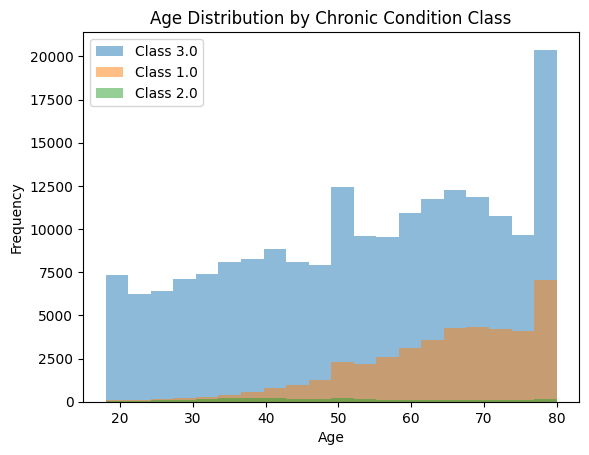

In [15]:
for class_label in y_train.unique():
    plt.hist(X_train[y_train == class_label]['Age'], alpha=0.5, bins=20, label=f'Class {class_label}')

plt.title('Age Distribution by Chronic Condition Class')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()


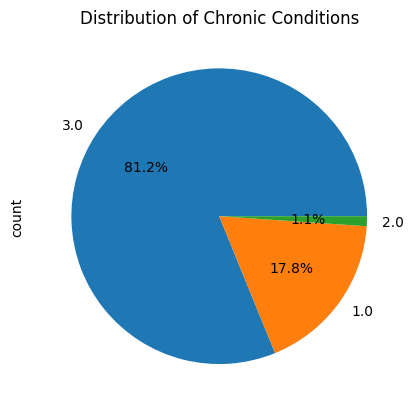

In [16]:
train['Chronic_Condition'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Chronic Conditions')
plt.show()

### We see an imbalance of the data for which we will apply SMOTE to ensure balanced model training

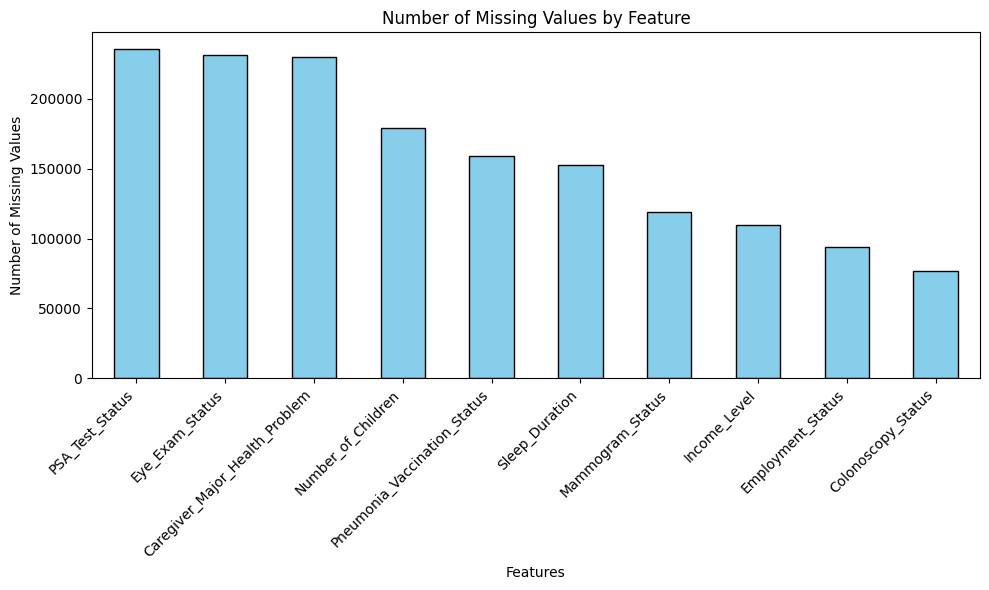

In [17]:
# Calculate the number of missing values for each feature
missing_values = train.isnull().sum()

# Filter out features with no missing values to focus on relevant features
missing_values = missing_values[missing_values > 0]

top_missing_values = missing_values.nlargest(10)

# Plot the missing values
plt.figure(figsize=(10, 6))
top_missing_values.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Missing Values by Feature')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


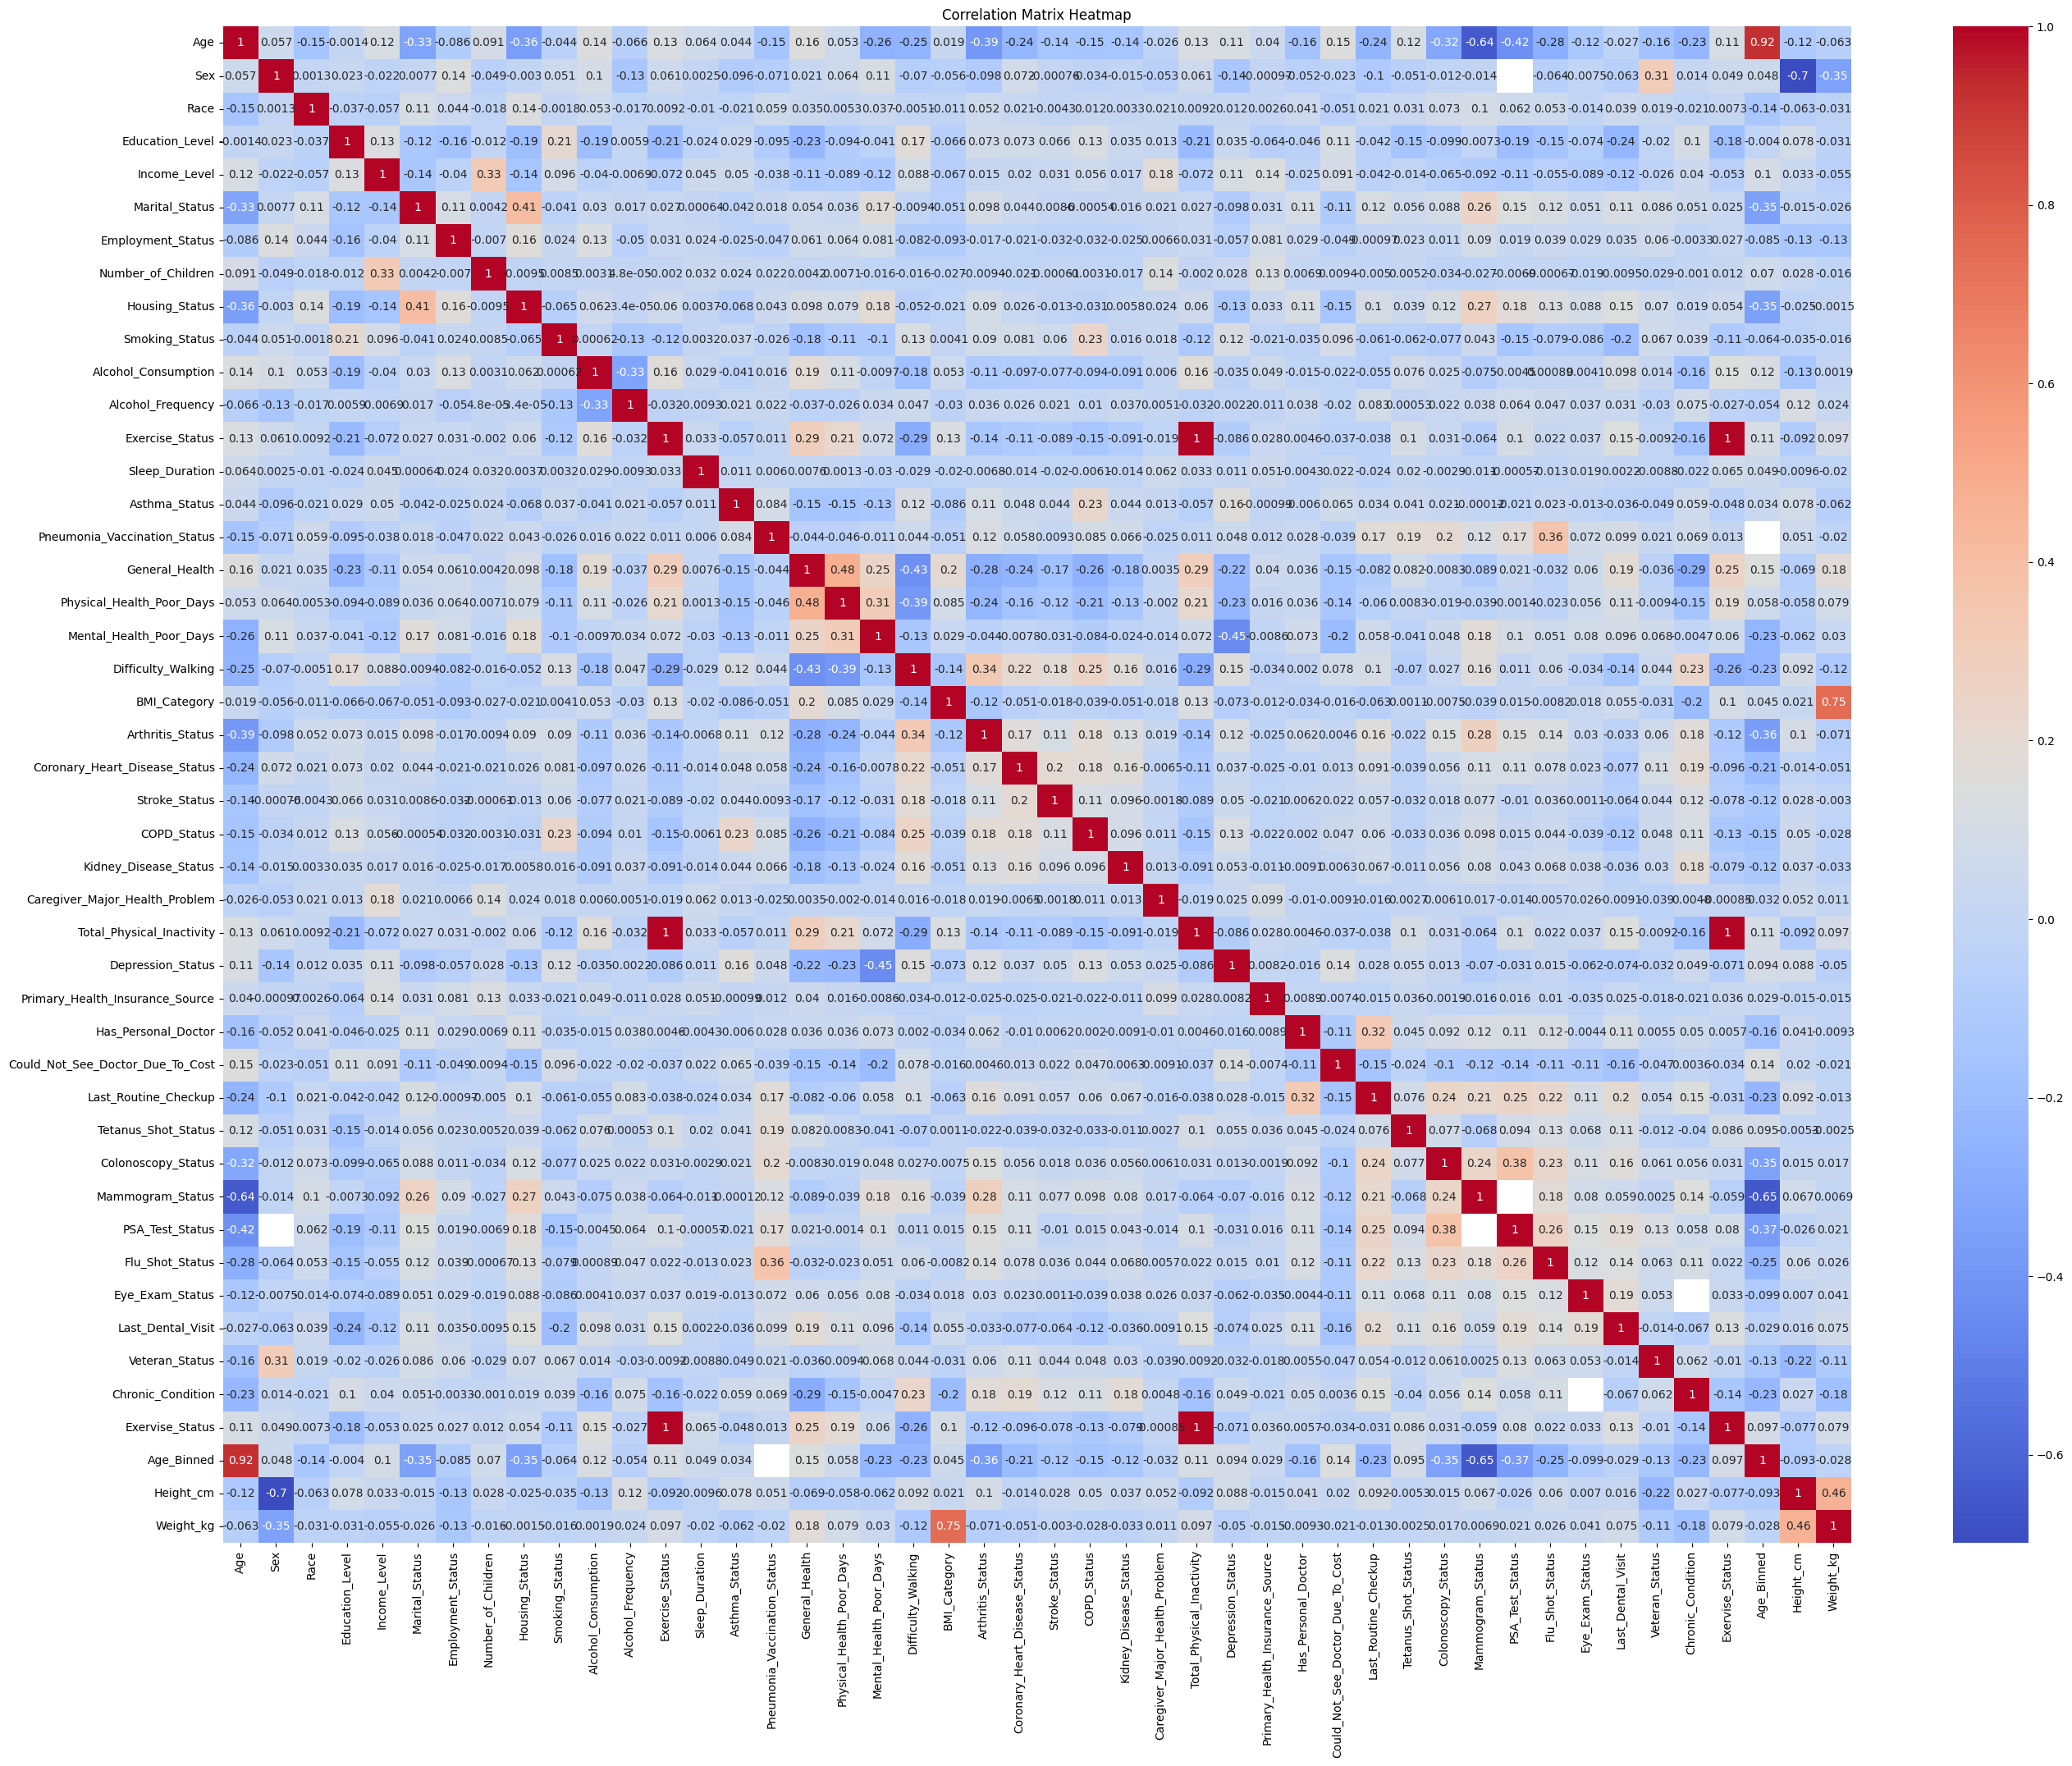

In [18]:
#correlation plot to see variables that are highly correlated
correlation_matrix = train.corr()

plt.figure(figsize=(32, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

### Filtering out highly correlated columns as seen in the darker red and blue blocks above. 

In [19]:
data = train
correlation_matrix = train.corr()

threshold = 0.8

columns_to_drop = set()

# Iterate over the correlation matrix to find pairs of highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            columns_to_drop.add(colname)

filtered_data = data.drop(columns=columns_to_drop)

# Print the columns that are dropped and those that remain
print(f"Columns dropped: {columns_to_drop}")
print(f"Remaining columns: {filtered_data.columns}")


Columns dropped: {'Exervise_Status', 'Total_Physical_Inactivity', 'Age_Binned'}
Remaining columns: Index(['Age', 'Sex', 'Race', 'Education_Level', 'Income_Level',
       'Marital_Status', 'Employment_Status', 'Number_of_Children',
       'Housing_Status', 'Smoking_Status', 'Alcohol_Consumption',
       'Alcohol_Frequency', 'Exercise_Status', 'Sleep_Duration',
       'Asthma_Status', 'Pneumonia_Vaccination_Status', 'General_Health',
       'Physical_Health_Poor_Days', 'Mental_Health_Poor_Days',
       'Difficulty_Walking', 'BMI_Category', 'Arthritis_Status',
       'Coronary_Heart_Disease_Status', 'Stroke_Status', 'COPD_Status',
       'Kidney_Disease_Status', 'Caregiver_Major_Health_Problem',
       'Depression_Status', 'Primary_Health_Insurance_Source',
       'Has_Personal_Doctor', 'Could_Not_See_Doctor_Due_To_Cost',
       'Last_Routine_Checkup', 'Tetanus_Shot_Status', 'Colonoscopy_Status',
       'Mammogram_Status', 'PSA_Test_Status', 'Flu_Shot_Status',
       'Eye_Exam_Status', 'L

### XGBoost selected.

### Model Evaluation

In [20]:
#Resetting data with filters 
train = filtered_data
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['Chronic_Condition']), train['Chronic_Condition'], test_size=0.2, random_state=42)

In [21]:
train.head()

,Age,Sex,Race,Education_Level,Income_Level,Marital_Status,Employment_Status,Number_of_Children,Housing_Status,Smoking_Status,...,Colonoscopy_Status,Mammogram_Status,PSA_Test_Status,Flu_Shot_Status,Eye_Exam_Status,Last_Dental_Visit,Veteran_Status,Chronic_Condition,Height_cm,Weight_kg
0,66.0,1,1.0,4.0,99.0,1.0,1.0,NaN,1.0,3.0,...,1.0,NaN,NaN,2.0,NaN,2.0,2.0,3.0,190.50,99.79024
1,74.0,1,1.0,6.0,NaN,1.0,NaN,NaN,1.0,3.0,...,1.0,NaN,NaN,1.0,NaN,1.0,1.0,3.0,180.34,77.11064
2,61.0,1,2.0,4.0,5.0,5.0,NaN,NaN,1.0,2.0,...,2.0,NaN,NaN,2.0,NaN,NaN,1.0,3.0,180.34,77.11064
3,44.0,2,1.0,6.0,3.0,5.0,1.0,NaN,2.0,4.0,...,NaN,2.0,NaN,1.0,NaN,4.0,2.0,3.0,157.48,68.03880
4,79.0,1,NaN,2.0,5.0,6.0,5.0,10.0,3.0,1.0,...,1.0,NaN,NaN,NaN,NaN,3.0,2.0,1.0,170.18,124.73780


In [22]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42),
}

# Train each model and evaluate its performance using a pipeline that includes imputation
results = {}
for name, model in models.items():
    # Create a pipeline with SimpleImputer to handle missing values and the model
    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
        ('model', model)
    ])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f'{name} Accuracy: {accuracy:.4f}')

# Find the best model
best_model_name = max(results, key=results.get)
best_model_score = results[best_model_name]

print(f'\nBest Model: {best_model_name} with Accuracy: {best_model_score:.4f}')

Random Forest Accuracy: 0.8488
Gradient Boosting Accuracy: 0.8508

Best Model: Gradient Boosting with Accuracy: 0.8508


### Looking into feature importances

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# Convert categorical features to numerical using one-hot encoding
train = pd.get_dummies(train, drop_first=True)

# Step 1: Prepare the data
X = train.drop(columns=['Chronic_Condition', 'Eye_Exam_Status'])
y = train['Chronic_Condition'] - 1  # Convert target labels to start from 0

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train an initial XGBoost model to determine feature importance
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Step 4: Get feature importances and select only the most important ones
importances = xgb_clf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_n = 20
important_features = importance_df['Feature'][:top_n].tolist()

# Step 5: Filter the data to only include the most important features
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

# Step 6: Train the XGBoost model again with only the 20 selected features
xgb_clf_selected = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=42)
xgb_clf_selected.fit(X_train_selected, y_train)

# Step 7: Make predictions and evaluate the model
y_pred = xgb_clf_selected.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model with selected features: {accuracy:.4f}")

# Display the most important features
print("Most Important Features:")
print(importance_df[:top_n])

Accuracy of the model with selected features: 0.8235
Most Important Features:
                          Feature  Importance
16                 General_Health    0.162977
1                             Sex    0.122104
20                   BMI_Category    0.092882
0                             Age    0.063986
25          Kidney_Disease_Status    0.049050
31           Last_Routine_Checkup    0.042682
19             Difficulty_Walking    0.037822
22  Coronary_Heart_Disease_Status    0.033027
6               Employment_Status    0.024255
11              Alcohol_Frequency    0.021502
7              Number_of_Children    0.020508
2                            Race    0.019183
15   Pneumonia_Vaccination_Status    0.019108
10            Alcohol_Consumption    0.019083
12                Exercise_Status    0.019077
40                      Weight_kg    0.017991
36                Flu_Shot_Status    0.017875
29            Has_Personal_Doctor    0.013291
23                  Stroke_Status    0.013024
3 

### We can see that General Health, Sex, BI and Age have great impact on chronic conditions. We will drill down into that more later.

In [24]:
#XGBoost 

# Prepare the data
X = train.drop(columns=['Chronic_Condition'])
y = train['Chronic_Condition'] - 1  # Convert target labels to start from 0 if needed

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model with label-encoded data
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_train = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_train)
print(f"Accuracy of the model on training set: {accuracy:.4f}")

Accuracy of the model on training set: 0.8513


## Model Optimization

### Hyperparameter tuning with GridSearchCV

In [25]:
# Prepare the data
X = train.drop(columns=['Chronic_Condition', 'Eye_Exam_Status'])
y = train['Chronic_Condition'] - 1  # Convert target labels to start from 0 if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [50, 100],
}

# Set up GridSearchCV with the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best Parameters:", best_params)

# Make predictions using the best model
y_pred_train = best_model.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred_train)
print(f"Accuracy of the best model on the test set: {accuracy:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   4.3s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   4.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   4.4s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   4.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   4.5s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   5.2s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   5.6s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   5.8s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   5.8s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   5.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   7.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_est

### GridSearchCV includes k-fold cross validation to ensure we are not over-fitting with best params

Given the high average accuracy and low SD, we can deduce that our model is performing well and is not overfitting!

In [26]:
from sklearn.metrics import classification_report

print("Classification Report (Train Set):")
print(classification_report(y_test, y_pred_train, digits=4))

Classification Report (Train Set):
              precision    recall  f1-score   support

         0.0     0.5889    0.2616    0.3622      8587
         1.0     0.0000    0.0000    0.0000       517
         2.0     0.8452    0.9601    0.8990     38896

    accuracy                         0.8248     48000
   macro avg     0.4780    0.4072    0.4204     48000
weighted avg     0.7902    0.8248    0.7933     48000

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Applying SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

pipeline = Pipeline([
    ('scaler', StandardScaler()),                
    ('xgb', XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=42))
])

param_grid = {
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__max_depth': [3, 5],
    'xgb__n_estimators': [50, 100]
}

# k-fold cross-validation
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train_smote, y_train_smote)

# Print best parameters 
print(f"Best Parameters: {grid_search.best_params_}")

# Make predictions on the test set with the parameters
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test_imputed)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=  10.6s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=  10.7s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=  11.7s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=  11.8s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=  12.1s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=50; total time=  14.8s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=50; total time=  14.8s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=50; total time=  15.2s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=50; total time=  15.3s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=50; total time=  15.3s
[CV] END xgb__learni

In [28]:
# Print classification report for the test set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test, digits=4))

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0     0.5669    0.2817    0.3764      8587
         1.0     0.0000    0.0000    0.0000       517
         2.0     0.8475    0.9529    0.8971     38896

    accuracy                         0.8226     48000
   macro avg     0.4715    0.4115    0.4245     48000
weighted avg     0.7882    0.8226    0.7943     48000

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

## Final Model Accuracy : 92% (with low learning rate, high depth)

In [29]:
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Cross-Validation Accuracy: 0.8933


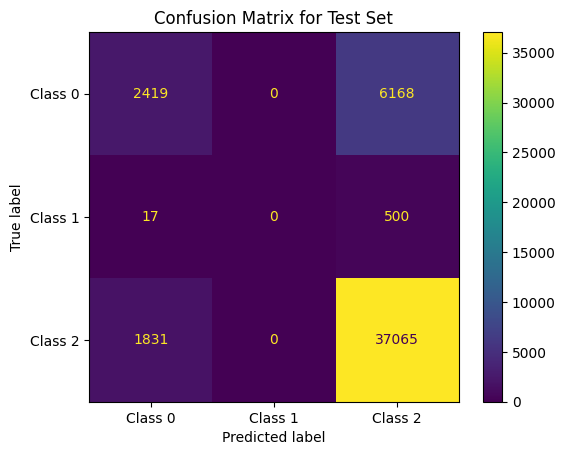

In [30]:
# Make predictions on the test set
y_pred_test = best_model.predict(X_test_imputed)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2'])  # Update display_labels if needed
disp.plot(cmap='viridis')
plt.title("Confusion Matrix for Test Set")
plt.show()

### Test Set Predictions

In [31]:
test = pd.read_csv('test.csv')
test = test.drop(columns=['Total_Physical_Inactivity', 'Eye_Exam_Status']) #remove unimportant features

test = preprocess_height(test)
test = preprocess_weight(test)

Sample height values after conversion:
   Height_cm
0     160.02
1     172.72
2     167.64
3     167.64
4        NaN
Sample weight values after conversion:
   Weight_kg
0   65.77084
1  122.46984
2   70.30676
3   72.57472
4  108.86208


In [32]:
test.head()

,Age,Sex,Race,Education_Level,Income_Level,Marital_Status,Employment_Status,Number_of_Children,Housing_Status,Smoking_Status,...,Last_Routine_Checkup,Tetanus_Shot_Status,Colonoscopy_Status,Mammogram_Status,PSA_Test_Status,Flu_Shot_Status,Last_Dental_Visit,Veteran_Status,Height_cm,Weight_kg
0,25,2,4,6.0,77.0,5.0,6.0,88.0,2.0,4,...,1.0,7.0,NaN,2.0,NaN,2.0,1.0,2.0,160.02,65.77084
1,67,1,1,4.0,2.0,5.0,7.0,88.0,2.0,3,...,1.0,3.0,2.0,NaN,NaN,1.0,4.0,2.0,172.72,122.46984
2,42,1,7,5.0,11.0,1.0,1.0,88.0,1.0,3,...,1.0,1.0,NaN,NaN,2.0,2.0,1.0,2.0,167.64,70.30676
3,45,2,1,6.0,9.0,1.0,1.0,2.0,1.0,4,...,1.0,1.0,2.0,1.0,NaN,2.0,1.0,2.0,167.64,72.57472
4,75,1,1,2.0,5.0,2.0,7.0,88.0,2.0,3,...,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,108.86208


In [33]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get the predicted probabilities on the test data
y_pred_probabilities = (pipeline.predict_proba(test))

# Create a DataFrame with predicted probabilities
prob_df = pd.DataFrame(y_pred_probabilities, columns=['Probability_Class_1', 'Probability_Class_2', 'Probability_Class_3'])

# Display the DataFrame
prob_df

,Probability_Class_1,Probability_Class_2,Probability_Class_3
0,0.007975,0.012737,0.979288
1,0.770799,0.000094,0.229107
2,0.100383,0.000160,0.899458
3,0.008146,0.037064,0.954790
4,0.403974,0.000010,0.596016
...,...,...,...
68804,0.450543,0.005521,0.543936
68805,0.071867,0.000133,0.928000
68806,0.009161,0.002047,0.988792
68807,0.049882,0.000021,0.950097


## Insight 

In [34]:
chronic_condition_key = {
    1: 'Chronic Condition',
    2: 'Chronic Condition during Pregnancy',
    3: 'No Chronic Condition'
}

exercise_key = {
    1 : 'Exercise Regularly',
    2 : 'Exercise Sometimes',
    7 : 'Inactivity',
    9 : 'Don’t know/Refused/Missing'
}


### Feature Importances

In [35]:
print("Most Important Features:")
print(importance_df[:top_n])

Most Important Features:
                          Feature  Importance
16                 General_Health    0.162977
1                             Sex    0.122104
20                   BMI_Category    0.092882
0                             Age    0.063986
25          Kidney_Disease_Status    0.049050
31           Last_Routine_Checkup    0.042682
19             Difficulty_Walking    0.037822
22  Coronary_Heart_Disease_Status    0.033027
6               Employment_Status    0.024255
11              Alcohol_Frequency    0.021502
7              Number_of_Children    0.020508
2                            Race    0.019183
15   Pneumonia_Vaccination_Status    0.019108
10            Alcohol_Consumption    0.019083
12                Exercise_Status    0.019077
40                      Weight_kg    0.017991
36                Flu_Shot_Status    0.017875
29            Has_Personal_Doctor    0.013291
23                  Stroke_Status    0.013024
3                 Education_Level    0.010658


### Using the feature importances above we drill down and can draw some insights about the key factors that impact chronic illness

In [36]:
general_health_key = {
    1.0: 'Excellent',
    2.0: 'Very good',
    3.0: 'Good',
    4.0: 'Fair',
    5.0: 'Poor',
    7.0: "Don't know/Not Sure",
    9.0: 'Refused'
}

train['General_Health_Desc'] = train['General_Health'].map(general_health_key)
train['Chronic_Condition'] = train['Chronic_Condition'].map(chronic_condition_key)

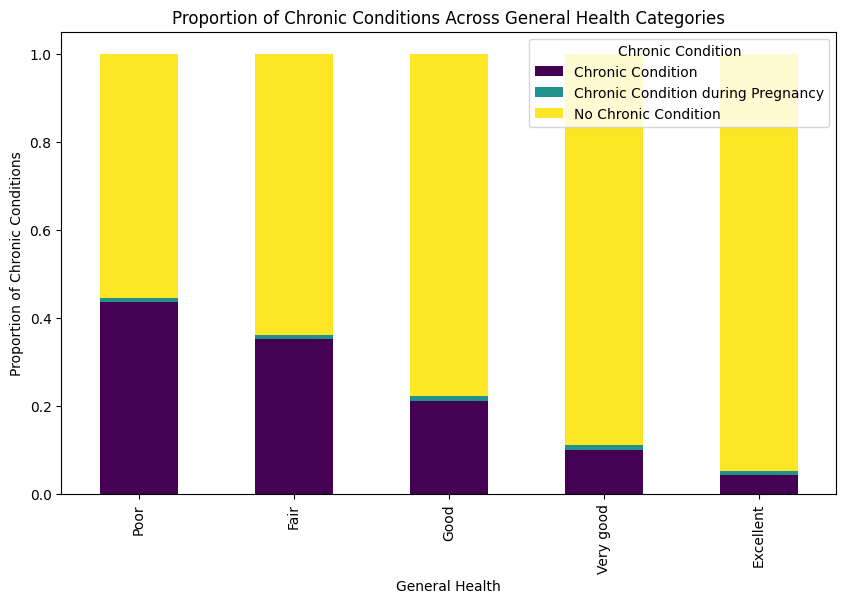

In [37]:
# Define the custom order for the 'General_Health_Desc' column
order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']

# Convert the 'General_Health_Desc' column to a categorical type with the defined order
train['General_Health_Desc'] = pd.Categorical(train['General_Health_Desc'], categories=order, ordered=True)

# Drop any NaN values in 'General_Health_Desc'
train = train.dropna(subset=['General_Health_Desc'])

# Create a crosstab for the stacked bar plot
general_health_crosstab = pd.crosstab(train['General_Health_Desc'], train['Chronic_Condition'], normalize='index')

# Plot the stacked bar plot
general_health_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Proportion of Chronic Conditions Across General Health Categories')
plt.xlabel('General Health')
plt.ylabel('Proportion of Chronic Conditions')
plt.legend(title='Chronic Condition')
plt.show()

### We can clearly see the link between general health  and chronic illness diagnosis.

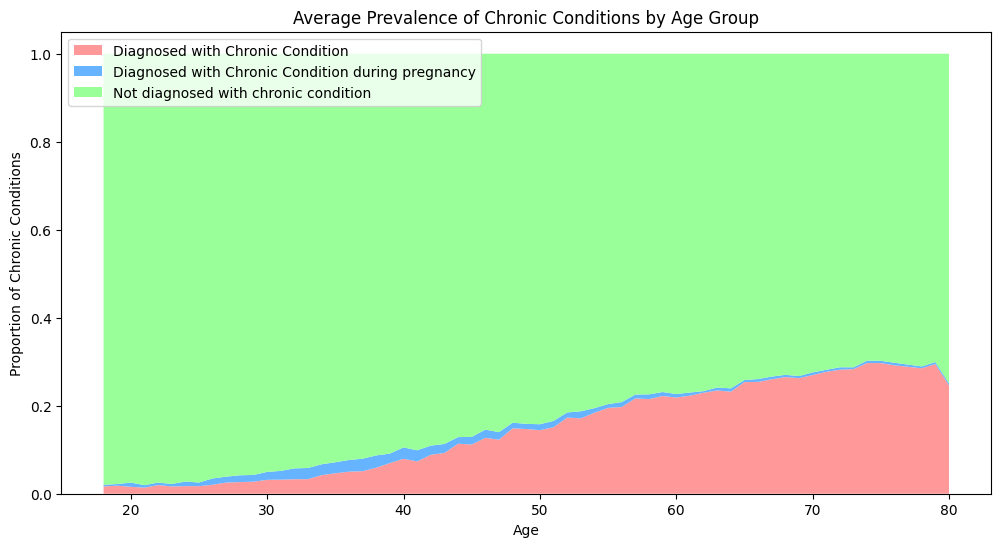

In [38]:
# Calculating average chronic condition prevalence by age group
avg_chronic_by_age = train.groupby('Age')['Chronic_Condition'].value_counts(normalize=True).unstack()

# Plotting as a stacked area plot
plt.figure(figsize=(12, 6))
plt.stackplot(avg_chronic_by_age.index, avg_chronic_by_age['Chronic Condition'], avg_chronic_by_age['Chronic Condition during Pregnancy'], avg_chronic_by_age['No Chronic Condition'], 
              labels=['Diagnosed with Chronic Condition', 'Diagnosed with Chronic Condition during pregnancy', 'Not diagnosed with chronic condition'],
              colors=['#ff9999','#66b3ff','#99ff99'])

plt.title('Average Prevalence of Chronic Conditions by Age Group')
plt.xlabel('Age')
plt.ylabel('Proportion of Chronic Conditions')
plt.legend(loc='upper left')
plt.show()

### Clearly, age is a large determinant in chronic illness due to the increase in diagnosed disease as the red area increases.

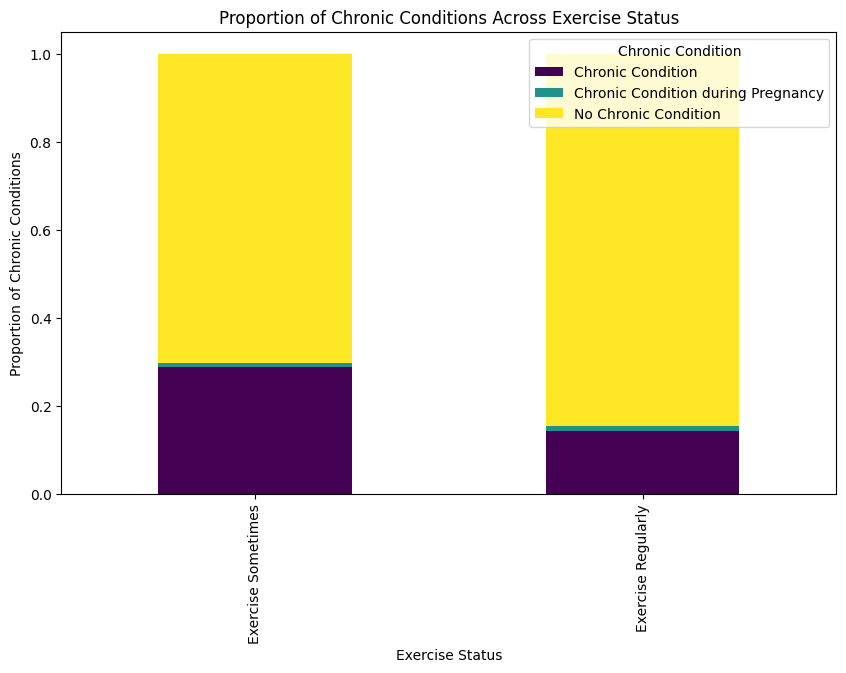

In [39]:
train['Exercise_Status_Desc'] = train['Exercise_Status'].map(exercise_key)

# Remove the "Don't know/Refused/Missing" from the Exercise_Status_Desc column
exercise_filtered = train[~train['Exercise_Status_Desc'].isin(["Don't know/Refused/Missing"])]

# Define the custom order for the remaining 'Exercise_Status_Desc' from least to most exercise
exercise_order = ['Inactivity', 'Exercise Sometimes', 'Exercise Regularly']

# Convert the 'Exercise_Status_Desc' column to a categorical type with the defined order
exercise_filtered['Exercise_Status_Desc'] = pd.Categorical(exercise_filtered['Exercise_Status_Desc'], categories=exercise_order, ordered=True)

# Re-plot using the new filtered data
exercise_crosstab = pd.crosstab(exercise_filtered['Exercise_Status_Desc'], exercise_filtered['Chronic_Condition'], normalize='index')

# Plot a stacked bar plot
exercise_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Proportion of Chronic Conditions Across Exercise Status')
plt.xlabel('Exercise Status')
plt.ylabel('Proportion of Chronic Conditions')
plt.legend(title='Chronic Condition')
plt.show()


### We see that the proportion of individuals who are diagnosed with chronic conditions is almost half for those who exercise regularly vs. those who only exercise sometimes.

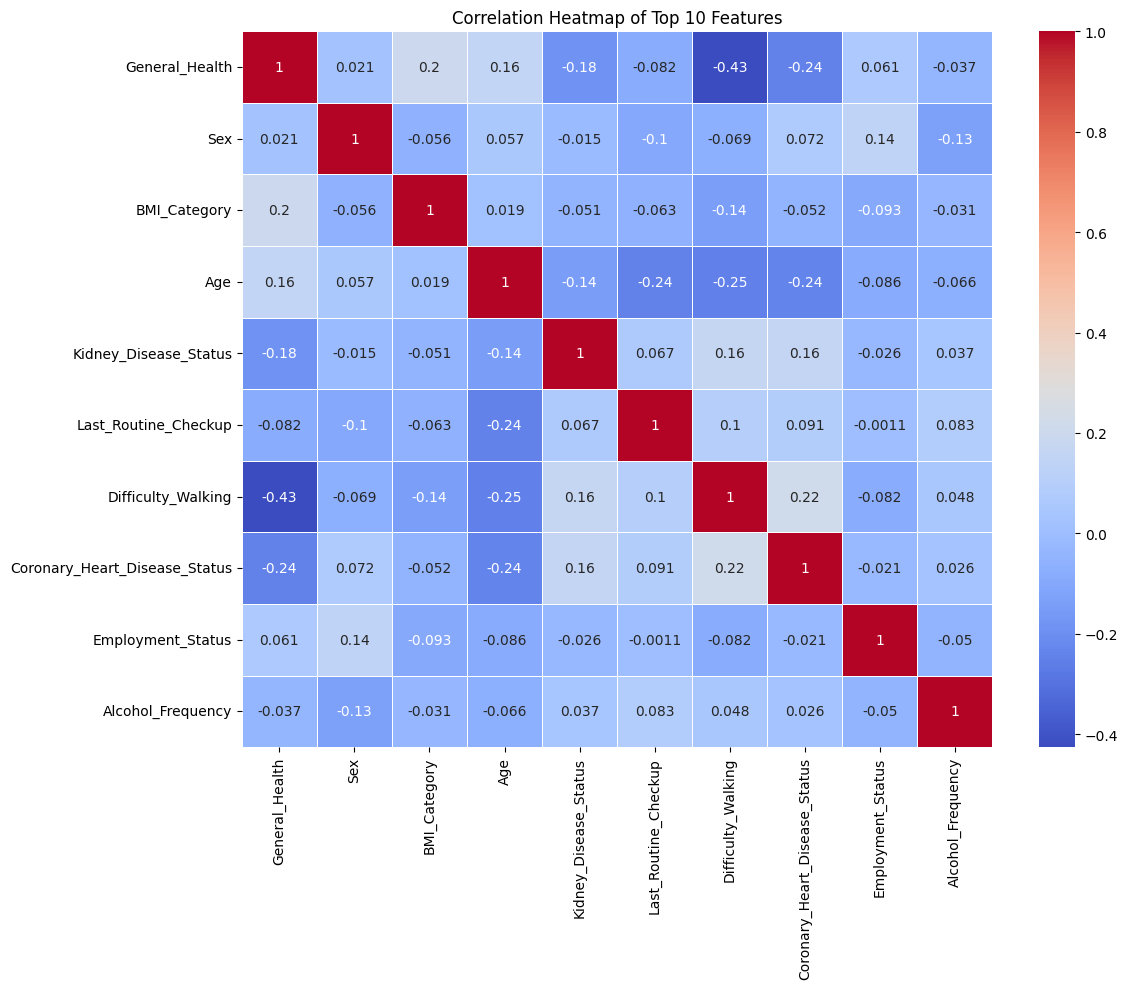

In [40]:
# Select only top N features based on importance
top_n = 10
importance_df_sorted = importance_df.sort_values('Importance', ascending=False)  
top_features = importance_df_sorted.head(top_n)['Feature']

# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(train[top_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Correlation Heatmap of Top {top_n} Features')
plt.tight_layout()
plt.show()


### No correlation between top variables - indicative of a healthy model

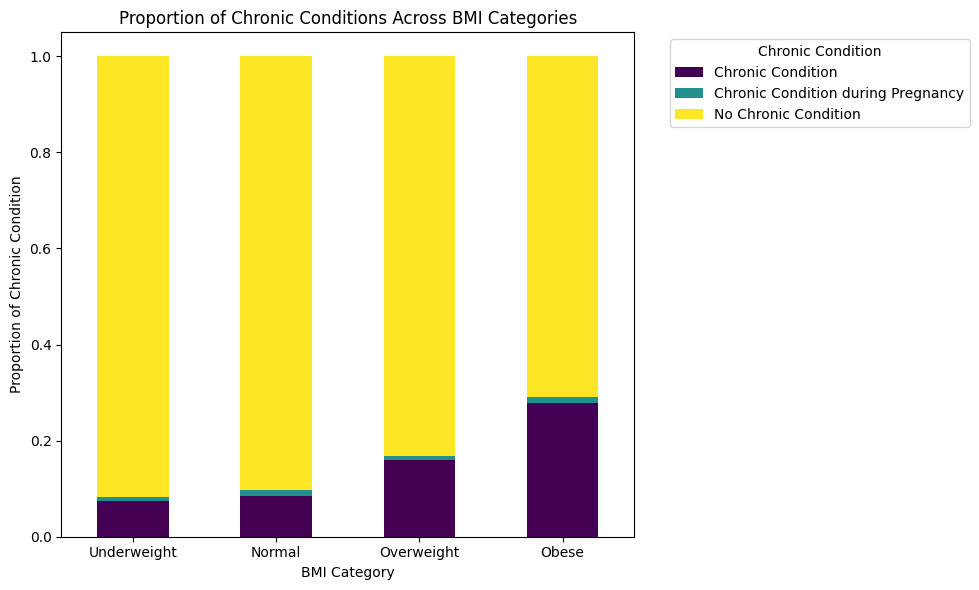

In [41]:
bmi_chronic = pd.crosstab(train['BMI_Category'], train['Chronic_Condition'], normalize='index')
bmi_chronic.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Proportion of Chronic Conditions Across BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Proportion of Chronic Condition')
plt.xticks([0, 1, 2, 3], ['Underweight', 'Normal', 'Overweight', 'Obese'], rotation=0)
plt.legend(title='Chronic Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### We see the trend that a higher BMI is linked to a higher proportion of chronic illness

# Appendix

Park, D.J., Park, M.W., Lee, H. et al. Development of machine learning model for diagnostic disease prediction based on laboratory tests. Sci Rep 11, 7567 (2021). https://doi.org/10.1038/s41598-021-87171-5

Lee, C., Jo, B., Woo, H., Im, Y., Park, R. W., & Park, C. H. (2024). Chronic disease prediction using the common data model: Development study. Artificial Intelligence in Medicine, 1(1), e41030. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11041444/pdf/ai_v1i1e41030.pdf

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16, 321-357. https://doi.org/10.1613/jair.953

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a80ea77f-f987-49a3-b9ea-16d29fcc67c9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>